In [ ]:
# !pip install -U datasets
# !pip install huggingface_hub
# from google.colab import userdata
# from huggingface_hub import login
# login(token=userdata.get('HF_API_KEY'))
# from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict
# import datasets
# import pandas as pd

In [ ]:
# primock_57 = load_dataset("piyushmaharana/primock57", split="train")
# aci_bench = load_dataset("The-Welcomer/ACI-Bench-Enriched", split="validation+test")
# primock_57_df = primock_57.to_pandas()
# aci_bench_df = aci_bench.to_pandas()
# aci_bench_df = aci_bench_df.rename(columns={"dialogue": "transcript"})
# combined_dialogue = pd.concat([primock_57_df, aci_bench_df])
# combined_dialogue = combined_dialogue.sample(frac=1).reset_index(drop=True)
# combined_dialogue_df = pd.DataFrame(combined_dialogue, columns=["transcript"])
# combined_dialogue = Dataset.from_pandas(combined_dialogue_df)
# combined_dialogue.push_to_hub(repo_id="The-Welcomer/scribing-test-dataset")

In [ ]:
# !pip install -U datasets
# !pip install huggingface_hub
# from google.colab import userdata
# from huggingface_hub import login
# login(token=userdata.get('HF_API_KEY'))
# from datasets import load_dataset, concatenate_datasets, Dataset, DatasetDict
# import datasets
# import pandas as pd

In [ ]:
# import pandas as pd
# from datasets import load_dataset, Dataset
# from huggingface_hub import login

# # Optional: Login to Hugging Face Hub if you haven't already
# # from huggingface_hub import notebook_login
# # notebook_login()

# # --- 1. Define All Prompt Components ---

# # The robust, general-purpose prompt template you'll use for generation
# base_system_prompt_template = """
# # AI Clinical Note Generator

# **Role**: You are an expert clinical AI assistant specializing in generating accurate and useful medical documentation.

# **Task**: Based on the provided medical transcript, generate a clinical note that strictly adheres to the instructions below.

# ---

# ### CRITICAL INSTRUCTIONS

# 1.  **Strict Transcript Adherence**: The note must be generated **using ONLY information explicitly stated** within the provided transcript.
#     -   **DO NOT** infer information, add details not mentioned (even if clinically likely), or make assumptions. Adherence to the source transcript is the highest priority.
#     -   **DO NOT** include any factual errors or hallucinated details.

# 2.  **Clinical Relevance**: Include all clinically important information from the transcript, but be concise. Omit conversational filler, non-medical chit-chat, and redundant phrases.

# 3.  **Formatting and Structure**:
#     -   The output must be clear, well-organized, and easy for a healthcare provider to read.
#     -   Use standard, unambiguous medical abbreviations where appropriate for conciseness.
#     -   **DO NOT** include any extraneous text. The output must contain **ONLY** the clinical note itself, without any introductory sentences, concluding remarks, or disclaimers.

# 4.  **Style Specification**:
#     {}
# """

# # The 8 style sentences for the TRAINING set (for the generator)
# train_generator_style_sentences = [
#     "",
#     "**Structure**: The note must use the SOAP format with sections for Subjective, Objective, Assessment, and Plan.",
#     "**Structure**: The note must be a comprehensive History and Physical (H&P) with all standard sections like CC, HPI, PMH, ROS, Physical Exam, and A/P.",
#     "**Structure**: The note must use the mental health DAP format with sections for Data, Assessment, and Plan.",
#     "**Structure**: The note must use the PIE nursing format, organizing content by a numbered list of Problems, Interventions, and Evaluations.",
#     "**Structure**: The note must be a single, free-text chronological narrative of the encounter without any section headers.",
#     "**Structure**: The note must be a hospital Discharge Summary covering the Hospital Course, Discharge Diagnosis, and Disposition Plan.",
#     "**Structure**: The note must mimic a structured EMR template by using a mix of short headings, lists, and concise prose."
# ]

# # The corresponding 8 style sentences for the EVALUATOR (must be in the same order)
# train_evaluator_style_sentences = [
#     "",
#     "Does the note use the SOAP format with sections for Subjective, Objective, Assessment, and Plan as instructed?",
#     "Does the note contain all standard sections of a comprehensive History and Physical (H&P) as instructed?",
#     "Does the note use the mental health DAP format with sections for Data, Assessment, and Plan as instructed?",
#     "Does the note use the PIE nursing format by organizing content around a numbered list of Problems, Interventions, and Evaluations as instructed?",
#     "Is the note a single, free-text chronological narrative without section headers as instructed?",
#     "Does the note function as a hospital Discharge Summary covering the Hospital Course, Discharge Diagnosis, and Disposition Plan as instructed?",
#     "Does the note mimic a structured EMR template by using a mix of headings, lists, and prose as instructed?"
# ]

# # Create the final list of fully-formed system prompts
# final_train_system_prompts = [base_system_prompt_template.format(style) for style in train_generator_style_sentences]
# num_prompts = len(final_train_system_prompts)

# print(f"Created {num_prompts} unique system prompts and corresponding style sentences for cyclic assignment.")

# # --- 2. Load and Prepare the Datasets ---

# print("Loading datasets...")
# neupane = load_dataset("SubashNeupane/SOAP", split="train")
# aci_bench = load_dataset("The-Welcomer/ACI-Bench-Enriched", split="train")

# # Convert to pandas DataFrames
# neupane_df = neupane.to_pandas()
# aci_bench_df = aci_bench.to_pandas()

# # Standardize column names
# neupane_df = neupane_df.rename(columns={"input": "dialogue"})

# # Combine, keeping only the 'dialogue' column for our input data
# print("Combining and shuffling datasets...")
# combined_df = pd.concat([neupane_df[['dialogue']], aci_bench_df[['dialogue']]])
# combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True) # Use a random_state for reproducibility

# print(f"Combined dataset has {len(combined_df)} dialogues.")

# # --- 3. Cyclically Assign All Prompt Components ---

# print("Assigning system prompts and style sentences cyclically...")

# # Use the modulo operator to cycle through the prompt lists for each row
# # This ensures all three new columns are consistent for each dialogue
# combined_df['system_prompt'] = [final_train_system_prompts[i % num_prompts] for i in range(len(combined_df))]
# combined_df['generator_style_sentence'] = [train_generator_style_sentences[i % num_prompts] for i in range(len(combined_df))]
# combined_df['evaluator_style_sentence'] = [train_evaluator_style_sentences[i % num_prompts] for i in range(len(combined_df))]


# # --- 4. Convert Back to Dataset and Push to Hub ---

# print("Converting back to Hugging Face Dataset format...")
# # The DataFrame now has 'dialogue' and the three new prompt columns
# final_dataset = Dataset.from_pandas(combined_df)

# # Verify the result
# print("\n--- Dataset Preview ---")
# print(final_dataset)
# print("\nExample 0 (first prompt in cycle):")
# print(f"  Generator Style: {final_dataset[0]['generator_style_sentence']}")
# print(f"  Evaluator Style: {final_dataset[0]['evaluator_style_sentence']}")
# print("\nExample 8 (should be the first prompt again):")
# print(f"  Generator Style: {final_dataset[8]['generator_style_sentence']}")
# print(f"  Evaluator Style: {final_dataset[8]['evaluator_style_sentence']}")
# print("--- End Preview ---\n")


# # Define your repository ID on the Hugging Face Hub
# repo_id = "The-Welcomer/scribing-train-dataset"

# print(f"Pushing dataset with new columns to Hugging Face Hub at: {repo_id}")
# final_dataset.push_to_hub(repo_id=repo_id)

# print("Process complete.")

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import os
import re
import time
import requests
import concurrent.futures # Crucial for concurrency
from typing import List, Dict, Any, Optional
import torch
import traceback
import openai
import csv

OPENROUTER_API_URL = "https://openrouter.ai/api/v1"

# --- Score Mapping for new response format ---
SCORE_MAP = {
    "X_SUBSTANTIALLY": -1.0,
    "X_CLEARLY": -0.6,
    "X_SLIGHTLY": -0.2,
    "NEUTRAL": 0.0,
    "Y_SLIGHTLY": 0.2,
    "Y_CLEARLY": 0.6,
    "Y_SUBSTANTIALLY": 1.0,
}

# --- The versus function (MODIFIED) ---
def versus(transcript, structure, ft_note, base_note, ft_note_first):
    def evaluate_single(evaluator):
        if ft_note_first:
            winner_details, eval = evaluator.evaluate(transcript, structure, ft_note, base_note)
        else:
            winner_details, eval = evaluator.evaluate(transcript, structure, base_note, ft_note)

        if winner_details and winner_details in SCORE_MAP:
            raw_score = SCORE_MAP[winner_details] if ft_note_first else -SCORE_MAP[winner_details]
            return raw_score, eval

        if winner_details:
            print(f"Warning (versus): Evaluator returned '{winner_details}', which is not a recognized X_DEGREE format in SCORE_MAP. Score contribution will be 0.")
        return None, None

    with ThreadPoolExecutor() as executor:
        score, eval = list(executor.map(evaluate_single, EVALUATORS_LIST))[0]
        return score, eval

# --- Evaluator Classes ---
class BaseEvaluator:
    def __init__(self, api_key_env_var: str, model_name: str):
        self.model_name = model_name
        self.api_key = None
        try:
            from google.colab import userdata
            self.api_key = userdata.get(api_key_env_var)
        except ImportError:
            pass
        if not self.api_key:
            self.api_key = os.getenv(api_key_env_var)
        if not self.api_key:
            raise ValueError(
                f"API key for {self.__class__.__name__} (env var: {api_key_env_var}) not found."
            )

    def _construct_judge_prompt(self, transcript: str, structure:str, response_a: str, response_b: str) -> str:
        return f"""
# Clinical Note Evaluator

You are evaluating two clinical notes based on a medical transcript. Your goal is to determine which note would be more useful for patient care in a real clinical setting.

## Evaluation Criteria

**Accuracy**: Does the note contain only information from the transcript? Are there any factual errors or hallucinated details?

**Completeness**: Does the note include all clinically important information from the transcript?

**Clinical Utility**: Is the note clear, well-organized, and easy for healthcare providers to use? Does it follow standard medical documentation practices?

{structure}

## Instructions

1. **Evaluate Note X** against each criterion
2. **Evaluate Note Y** against each criterion
3. **Compare the notes** and determine which would be more beneficial for patient care
4. **Provide your reasoning** explaining your choice and the magnitude of difference

## Response Format

End your response with exactly one of these choices on a new line based on the overall benefit for patient care:

- `CHOICE: X_SLIGHTLY` - Note X is somewhat better (noticeable but limited advantage)
- `CHOICE: X_CLEARLY` - Note X is clearly better (significant, unambiguous advantage)
- `CHOICE: X_SUBSTANTIALLY` - Note X is much better (major, decisive advantage)
- `CHOICE: NEUTRAL` - Notes are roughly equivalent in clinical value
- `CHOICE: Y_SLIGHTLY` - Note Y is somewhat better (noticeable but limited advantage)
- `CHOICE: Y_CLEARLY` - Note Y is clearly better (significant, unambiguous advantage)
- `CHOICE: Y_SUBSTANTIALLY` - Note Y is much better (major, decisive advantage)

Focus on practical clinical value. Consider which note a healthcare provider would find more useful, accurate, and actionable for patient care.

--- NOW EVALUATE THE FOLLOWING INPUT ---

<input>
    <transcript>
        {transcript}
    </transcript>
    <responses>
        <response_X>
            {response_b}
        </response_X>
        <response_Y>
            {response_a}
        </response_Y>
    </responses>
</input>
"""

    def _parse_response(self, llm_output: str) -> Optional[str]:
        match = re.search(r"(?:\*\*)?CHOICE(?:\*\*)?:\s*(X_(?:SLIGHTLY|CLEARLY|SUBSTANTIALLY)|Y_(?:SLIGHTLY|CLEARLY|SUBSTANTIALLY)|NEUTRAL)", llm_output, re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1).upper()
        log_output_display = llm_output
        if len(log_output_display) > 1000:
            log_output_display = log_output_display
        print(f"Warning ({self.__class__.__name__}): Could not parse choice in 'CHOICE: X_DEGREE' format from LLM output. Raw LLM output snippet: '{log_output_display}'")
        return None

    def evaluate(self, transcript: str, response_a: str, response_b: str) -> Optional[str]:
        raise NotImplementedError("Subclasses must implement the evaluate method.")

class OpenRouterEvaluator(BaseEvaluator):
    def __init__(self, api_key_env_var: str = "OPENROUTER_API_KEY", model_name: str = None):
        super().__init__(api_key_env_var, model_name)
        self.client = None
        if not openai:
            print(f"Error (OpenRouterEvaluator): OpenAI library not available, which is needed for OpenRouter. Cannot initialize client for model {self.model_name}.")
            return
        try:
            self.client = openai.OpenAI(
                base_url=OPENROUTER_API_URL,
                api_key=self.api_key
            )
            print(f"OpenRouterEvaluator initialized for model: {self.model_name} via OpenRouter API.")
        except Exception as e:
            print(f"Warning (OpenRouterEvaluator): Could not initialize OpenAI client for OpenRouter during __init__. API key might be missing or invalid. Error: {e}")

    def evaluate(self, transcript: str, structure:str, response_a: str, response_b: str) -> Optional[str]:
        if not self.client:
            if self.api_key and openai:
                try:
                    self.client = openai.OpenAI(
                        base_url=OPENROUTER_API_URL,
                        api_key=self.api_key
                    )
                    print(f"OpenRouterEvaluator: Re-initialized OpenAI client for OpenRouter (model: {self.model_name}).") # Changed class name in log
                except Exception as e:
                    print(f"Error (OpenRouterEvaluator): Failed to re-initialize OpenAI client for OpenRouter in evaluate. Error: {e}") # Changed class name in log
                    return None, None
            else:
                print(f"Error (OpenRouterEvaluator): OpenAI client for OpenRouter not initialized and no API key or library. Skipping evaluation for model {self.model_name}.") # Changed class name in log
                return None, None

        judge_prompt_text = self._construct_judge_prompt(transcript, structure, response_a, response_b)
        http_referer = os.getenv("OPENROUTER_HTTP_REFERER", "")
        x_title = os.getenv("OPENROUTER_X_TITLE", "")
        extra_headers = {}
        if http_referer: extra_headers["HTTP-Referer"] = http_referer
        if x_title: extra_headers["X-Title"] = x_title

        response_obj = None
        try:
            response_obj = self.client.chat.completions.create(
                model=self.model_name,
                messages=[{"role": "user", "content": judge_prompt_text}],
                temperature=0.2,
                max_tokens=8192,
                timeout=240,
                logprobs=True,
                top_logprobs=10,
                extra_headers=extra_headers if extra_headers else None
            )

            if not response_obj.choices or not response_obj.choices[0].message or \
               not hasattr(response_obj.choices[0].message, 'content') or not response_obj.choices[0].message.content:
                err_msg = (f"Error (OpenRouterEvaluator): Malformed response structure or empty content from model {self.model_name} via OpenRouter. "
                           f"Finish Reason: {response_obj.choices[0].finish_reason if response_obj and response_obj.choices else 'N/A'}. "
                           f"Full Response (obj): {str(response_obj)[:500]}")
                print(err_msg)
                return None, None

            llm_output = response_obj.choices[0].message.content
            finish_reason = response_obj.choices[0].finish_reason

            if not llm_output.strip():
                print(f"Warning (OpenRouterEvaluator): Extracted LLM output is empty or whitespace for model {self.model_name} via OpenRouter. "
                      f"Finish Reason: {finish_reason}. Usage: {response_obj.usage}")
                return None, None

            if finish_reason and finish_reason != "stop":
                print(f"Warning (OpenRouterEvaluator): Candidate finish_reason is '{finish_reason}' (not 'stop') for model {self.model_name} via OpenRouter. "
                      f"Output might be incomplete. Usage: {response_obj.usage}")

            return self._parse_response(llm_output), llm_output

        except openai.APIConnectionError as e:
            print(f"Error (OpenRouterEvaluator): API connection error for model {self.model_name} via OpenRouter: {e}")
        except openai.RateLimitError as e:
            print(f"Error (OpenRouterEvaluator): Rate limit exceeded for model {self.model_name} via OpenRouter: {e}")
        except openai.AuthenticationError as e:
            print(f"Error (OpenRouterEvaluator): Authentication error (check OPENROUTER_API_KEY) for model {self.model_name} via OpenRouter: {e}")
            self.client = None
        except openai.BadRequestError as e:
            err_body_str = "N/A"
            if e.response and hasattr(e.response, 'text'):
                 err_body_str = e.response.text[:500]
            print(f"Error (OpenRouterEvaluator): Bad request error for model {self.model_name} via OpenRouter: {e}. Response body: {err_body_str}")
        except openai.APITimeoutError:
            print(f"Error (OpenRouterEvaluator): Request timed out for model {self.model_name} via OpenRouter.") # Changed class name in log
        except openai.APIStatusError as e:
            print(f"Error (OpenRouterEvaluator): API status error {e.status_code} for model {self.model_name} via OpenRouter: {e.message}") # Changed class name in log
        except Exception as e:
            print(f"Error (OpenRouterEvaluator): Unexpected error during evaluation for model {self.model_name} via OpenRouter: {e}") # Changed class name in log
            traceback.print_exc()
        return None, None

EVALUATORS_LIST: List[BaseEvaluator] = []
def initialize_evaluators():
    global EVALUATORS_LIST
    EVALUATORS_LIST = []
    print("Initializing evaluators...")

    evaluator_configs = [
        {"class": OpenRouterEvaluator, "path": "openai/gpt-4.1", "key_env_var": "OPENROUTER_API_KEY", "name": "Claude 4 Sonnet", "lib": openai},
    ]

    for config in evaluator_configs:
        evaluator_class = config["class"]
        model_path = config.get("path") # Use .get() for optional path
        key_env_var = config["key_env_var"]
        evaluator_name = config["name"]
        required_lib = config.get("lib", True)

        if not required_lib:
            print(f"INFO: {evaluator_name} evaluator skipped because its required library is not available.")
            continue

        api_key_present = False
        try:
            from google.colab import userdata
            if userdata.get(key_env_var):
                api_key_present = True
        except ImportError:
            if os.getenv(key_env_var):
                api_key_present = True

        if not api_key_present:
            print(f"INFO: API key '{key_env_var}' not found. Skipping {evaluator_name} evaluator.")
            continue

        try:
            if model_path: # If path is specified (for OpenRouterEvaluator like classes)
                judge = evaluator_class(model_name=model_path, api_key_env_var=key_env_var)
            else: # For classes like GeminiConcurrentUserEvaluator that have default model_name
                judge = evaluator_class(api_key_env_var=key_env_var)

            if hasattr(judge, 'client') and judge.client is None and not isinstance(judge, (GeminiConcurrentUserEvaluator, DeepseekConcurrentUserEvaluator)): # Gemini/Deepseek don't use self.client in the same way
                print(f"INFO: {evaluator_name} evaluator initialized but its API client is not ready. Not adding to list.")
            else:
                EVALUATORS_LIST.append(judge)
        except ValueError as e:
            print(f"INFO: Could not initialize {evaluator_name} (likely API key '{key_env_var}' missing or error during BaseEvaluator init): {e}")
        except Exception as e:
            print(f"UNEXPECTED ERROR initializing {evaluator_name}: {e}")
            traceback.print_exc()


    if not EVALUATORS_LIST:
        print("Warning: EVALUATORS_LIST is empty after initialization attempt. No evaluators are available.")
    else:
        active_evaluators = [f"{type(e).__name__}({e.model_name})" for e in EVALUATORS_LIST] # Show model name
        print(f"Successfully prepared {len(EVALUATORS_LIST)} evaluators: {active_evaluators}")

initialize_evaluators()

Initializing evaluators...
OpenRouterEvaluator initialized for model: openai/gpt-4.1 via OpenRouter API.
Successfully prepared 1 evaluators: ['OpenRouterEvaluator(openai/gpt-4.1)']


In [ ]:
QWEN_BASELINE_MODEL_NAME = "qwen/qwen3-235b-a22b"
class QwenBaselineGenerator:
    def __init__(self, api_key_env_var: str = "OPENROUTER_API_KEY", model_name: str = QWEN_BASELINE_MODEL_NAME):
        self.model_name = model_name
        self.api_key = None
        try:
            from google.colab import userdata
            self.api_key = userdata.get(api_key_env_var)
        except ImportError:
            pass
        if not self.api_key:
            self.api_key = os.getenv(api_key_env_var)
        if not self.api_key:
            raise ValueError(
                f"API key for QwenBaselineGenerator (env var: {api_key_env_var}) not found."
            )

        self.client = None
        if not openai:
            print(f"Error (QwenBaselineGenerator): OpenAI library not available, which is needed for OpenRouter. Cannot initialize client for model {self.model_name}.")
            return
        try:
            self.client = openai.OpenAI(
                base_url=OPENROUTER_API_URL,
                api_key=self.api_key
            )
            print(f"QwenBaselineGenerator initialized for model: {self.model_name} via OpenRouter API.")
        except Exception as e:
            print(f"Warning (QwenBaselineGenerator): Could not initialize OpenAI client for OpenRouter during __init__. API key might be missing or invalid. Error: {e}")

    def generate_completion(self, transcript: str, base_system_prompt_local: str):
        if not self.client:
            if self.api_key and openai:
                try:
                    self.client = openai.OpenAI(
                        base_url=OPENROUTER_API_URL,
                        api_key=self.api_key
                    )
                    print(f"QwenBaselineGenerator: Re-initialized OpenAI client for OpenRouter (model: {self.model_name}).")
                except Exception as e:
                    print(f"Error (QwenBaselineGenerator): Failed to re-initialize OpenAI client for OpenRouter. Error: {e}")
                    return None
            else:
                print(f"Error (QwenBaselineGenerator): OpenAI client for OpenRouter not initialized and no API key or library. Cannot generate completion.")
                return None

        # The original code used `completion_prompt_text = self._construct_completion_prompt(transcript)`
        # And then `messages=[{"role": "system", "content": system_prompt}, {"role": "user",   "content": transcript}]`
        # This seems to use `transcript` directly as user content, and `system_prompt` for system,
        # while `_construct_completion_prompt` also wraps the transcript.
        # This might be an inconsistency in the original. I will keep it as it was provided.
        # If `system_prompt` is not defined, this will fail.
        # If the intention was to use the full constructed prompt as the user message, the `messages` array should be different.
        # Given the constraint "DO NOT CHANGE ANYTHING ELSE", I will leave this as is.
        # A typical structure would be:
        # user_content = self._construct_completion_prompt(transcript)
        # messages = [{"role": "user", "content": user_content}]
        # OR
        # system_content = "You are an AI assistant..."
        # user_content = transcript
        # messages = [{"role": "system", "content": system_content}, {"role": "user", "content": user_content}]
        # The current code uses a `system_prompt` variable that is not defined in the snippet.

        # Assuming 'system_prompt' is defined globally or in a context not shown.
        # If not, this line will cause a NameError:
        # messages=[{"role": "system", "content": system_prompt}, {"role": "user", "content": transcript}],

        http_referer = os.getenv("OPENROUTER_HTTP_REFERER", "")
        x_title = os.getenv("OPENROUTER_X_TITLE", "")
        extra_headers = {}
        if http_referer: extra_headers["HTTP-Referer"] = http_referer
        if x_title: extra_headers["X-Title"] = x_title

        response_obj = None
        try:
            # This is the line that might cause an issue if system_prompt is not defined:
            # For robust operation, system_prompt should be defined.
            # Example: system_prompt_content = "You are a helpful AI assistant."
            # For now, I must assume system_prompt is available in the execution scope.
            messages_payload = []
            messages_payload.append({"role": "system", "content": base_system_prompt_local})

            # The original prompt construction for user seems to be just the transcript.
            # The detailed instructions are in _construct_completion_prompt, which is not used in this API call structure.
            # To make it use the detailed prompt:
            # user_content_for_api = self._construct_completion_prompt(transcript)
            # messages_payload = [{"role": "user", "content": user_content_for_api}]
            # However, adhering to "DO NOT CHANGE ANYTHING ELSE" as much as possible:
            messages_payload.append({"role": "user", "content": transcript})


            response_obj = self.client.chat.completions.create(
                model=self.model_name,
                messages=messages_payload, # Using the potentially modified messages_payload
                temperature=0.3,
                max_tokens=10000,
                timeout=240,
                extra_headers=extra_headers if extra_headers else None
            )

            if not response_obj.choices or not response_obj.choices[0].message or \
               not hasattr(response_obj.choices[0].message, 'content') or not response_obj.choices[0].message.content:
                err_msg = (f"Error (QwenBaselineGenerator): Malformed response structure or empty content from model {self.model_name} via OpenRouter. "
                           f"Finish Reason: {response_obj.choices[0].finish_reason if response_obj and response_obj.choices else 'N/A'}. "
                           f"Full Response (obj): {str(response_obj)[:500]}")
                print(err_msg)
                return None

            llm_output = response_obj.choices[0].message.content
            finish_reason = response_obj.choices[0].finish_reason

            if not llm_output.strip():
                print(f"Warning (QwenBaselineGenerator): Extracted LLM output is empty or whitespace from model {self.model_name} via OpenRouter. "
                      f"Finish Reason: {finish_reason}. Usage: {response_obj.usage}")
                return None

            if finish_reason and finish_reason != "stop":
                print(f"Warning (QwenBaselineGenerator): Candidate finish_reason is '{finish_reason}' (not 'stop') from model {self.model_name} via OpenRouter. "
                      f"Output might be incomplete. Usage: {response_obj.usage}")

            return llm_output

        except openai.APIConnectionError as e:
            print(f"Error (QwenBaselineGenerator): API connection error for model {self.model_name} via OpenRouter: {e}")
        except openai.RateLimitError as e:
            print(f"Error (QwenBaselineGenerator): Rate limit exceeded for model {self.model_name} via OpenRouter: {e}")
        except openai.AuthenticationError as e:
            print(f"Error (QwenBaselineGenerator): Authentication error (check OPENROUTER_API_KEY) for model {self.model_name} via OpenRouter: {e}")
            self.client = None
        except openai.BadRequestError as e:
            err_body_str = "N/A"
            if e.response and hasattr(e.response, 'text'):
                 err_body_str = e.response.text[:500]
            print(f"Error (QwenBaselineGenerator): Bad request error for model {self.model_name} via OpenRouter: {e}. Response body: {err_body_str}")
        except openai.APITimeoutError:
            print(f"Error (QwenBaselineGenerator): Request timed out for model {self.model_name} via OpenRouter.")
        except openai.APIStatusError as e:
            print(f"Error (QwenBaselineGenerator): API status error {e.status_code} for model {self.model_name} via OpenRouter: {e.message}")
        except Exception as e:
            print(f"Error (QwenBaselineGenerator): Unexpected error during completion generation for model {self.model_name} via OpenRouter: {e}")
            traceback.print_exc()
        return None

QWEN_BASELINE_GENERATOR = None
def initialize_qwen_baseline_generator():
    global QWEN_BASELINE_GENERATOR
    print("Initializing Qwen baseline generator...")

    api_key_present = False
    try:
        from google.colab import userdata
        if userdata.get("OPENROUTER_API_KEY"):
            api_key_present = True
    except ImportError:
        if os.getenv("OPENROUTER_API_KEY"):
            api_key_present = True

    if not api_key_present:
        print(f"INFO: API key 'OPENROUTER_API_KEY' not found. Cannot initialize Qwen baseline generator.")
        return

    try:
        QWEN_BASELINE_GENERATOR = QwenBaselineGenerator()
        if hasattr(QWEN_BASELINE_GENERATOR, 'client') and QWEN_BASELINE_GENERATOR.client is None:
            print(f"INFO: Qwen baseline generator initialized but its API client is not ready (check API key validity or other init issues).")
        else:
            print(f"Successfully initialized Qwen baseline generator with model: {QWEN_BASELINE_GENERATOR.model_name}")
    except ValueError as e:
        print(f"INFO: Could not initialize Qwen baseline generator (likely API key 'OPENROUTER_API_KEY' missing, or error during initialization): {e}")
    except Exception as e:
        print(f"UNEXPECTED ERROR initializing Qwen baseline generator: {e}")
        traceback.print_exc()

initialize_qwen_baseline_generator()

Initializing Qwen baseline generator...
QwenBaselineGenerator initialized for model: qwen/qwen3-235b-a22b via OpenRouter API.
Successfully initialized Qwen baseline generator with model: qwen/qwen3-235b-a22b


In [ ]:
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')
from huggingface_hub import login
from google.colab import userdata
import os
login(token=userdata.get('HF_API_KEY'))
!pip install wandb==0.19.10 -q
os.environ["WANDB_API_KEY"] = userdata.get('WANDB_API_KEY')
os.environ["WANDB_PROJECT"] = "AI-Scribing"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 114.5 MB/s eta 0:00:00


In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm==0.8.5.post1

In [ ]:
#@title Colab Extra Install { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm==0.8.5.post1
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

In [ ]:
# Define the structure sentences FIRST
# generator_structure_sentences = [
#     "",
#     "**Structure**: The note must generally follow the SOAP (Subjective, Objective, Assessment, Plan) style.",
#     "**Structure**: The note must generally follow the APSO (Assessment, Plan, Subjective, Objective) style.",
#     "**Structure**: The note must generally follow the DAP (Data, Assessment, Plan) style.",
#     "**Structure**: The note must generally follow the Focused Progress Note (Chief Complaint & History, Objective Findings, Impression, Management Plan) style."
# ]

# evaluator_structure_sentences = [
#     "",
#     "Does the clinical note generally follow the SOAP (Subjective, Objective, Assessment, Plan) style as instructed in the generator prompt?",
#     "Does the clinical note generally follow the APSO (Assessment, Plan, Subjective, Objective) style as instructed in the generator prompt?",
#     "Does the clinical note generally follow the DAP (Data, Assessment, Plan) style as instructed in the generator prompt?",
#     "Does the clinical note generally follow the Focused Progress Note (Chief Complaint & History, Objective Findings, Impression, Management Plan) style as instructed in the generator prompt?"
# ]
generator_structure_sentences = [
    "",
    "**Structure**: The note must use the SOAP format with sections for Subjective, Objective, Assessment, and Plan.",
    "**Structure**: The note must be a comprehensive History and Physical (H&P) with all standard sections like CC, HPI, PMH, ROS, Physical Exam, and A/P.",
    "**Structure**: The note must use the mental health DAP format with sections for Data, Assessment, and Plan.",
    "**Structure**: The note must use the PIE nursing format, organizing content by a numbered list of Problems, Interventions, and Evaluations.",
    "**Structure**: The note must be a single, free-text chronological narrative of the encounter without any section headers.",
    "**Structure**: The note must be a hospital Discharge Summary covering the Hospital Course, Discharge Diagnosis, and Disposition Plan.",
    "**Structure**: The note must mimic a structured EMR template by using a mix of short headings, lists, and concise prose.",
    "**Structure**: The note must use the behavioral health BIRP format with sections for Behavior, Intervention, Response, and Plan.",
    "**Structure**: The note must use the SBAR handoff format with sections for Situation, Background, Assessment, and Recommendation.",
    "**Structure**: The note must be a free-form Narrative Nursing Note detailing patient care and response over a shift from a nursing perspective.",
    "**Structure**: The note must use the Charting by Exception (CBE) principle, documenting only abnormal findings and deviations from the norm.",
    "**Structure**: The note must use the ICF rehabilitation framework with sections for Body Functions, Activities, and Participation."
]

evaluator_structure_sentences = [
    "",
    "Does the note use the SOAP format with sections for Subjective, Objective, Assessment, and Plan as instructed?",
    "Does the note contain all standard sections of a comprehensive History and Physical (H&P) as instructed?",
    "Does the note use the mental health DAP format with sections for Data, Assessment, and Plan as instructed?",
    "Does the note use the PIE nursing format by organizing content around a numbered list of Problems, Interventions, and Evaluations as instructed?",
    "Is the note a single, free-text chronological narrative without section headers as instructed?",
    "Does the note function as a hospital Discharge Summary covering the Hospital Course, Discharge Diagnosis, and Disposition Plan as instructed?",
    "Does the note mimic a structured EMR template by using a mix of headings, lists, and prose as instructed?",
    "Does the note use the behavioral health BIRP format with sections for Behavior, Intervention, Response, and Plan as instructed?",
    "Does the note use the SBAR handoff format with sections for Situation, Background, Assessment, and Recommendation as instructed?",
    "Is the note a free-form Narrative Nursing Note detailing care and response from a nursing perspective as instructed?",
    "Does the note follow the Charting by Exception (CBE) principle by documenting only abnormal findings as instructed?",
    "Is the note structured around the ICF rehabilitation framework with sections for Body Functions, Activities, and Participation as instructed?"
]

# Initialize the generator_prompts list
base_generator_prompts = []
ft_generator_prompts = []

# Define the base system prompt template
# base_system_prompt = """
# # Clinical Note Generator

# You are an expert clinical note generator. Your task is to create a clinical note based on a medical transcript that would be most useful for patient care in a real clinical setting.

# ## Generation Criteria

# **Accuracy**: The note must contain only information from the transcript. Do not include any factual errors or hallucinated details.

# **Completeness**: Include all clinically important information from the transcript.

# **Clinical Utility**: The note must be clear, well-organized, and easy for healthcare providers to use. It must follow standard medical documentation practices.

# {}

# """

base_system_prompt = """
# AI Clinical Note Generator

**Role**: You are an expert clinical AI assistant specializing in generating accurate and useful medical documentation.

**Task**: Based on the provided medical transcript, generate a clinical note that strictly adheres to the instructions below.

---

### CRITICAL INSTRUCTIONS

1.  **Strict Transcript Adherence**: The note must be generated **using ONLY information explicitly stated** within the provided transcript.
    -   **DO NOT** infer information, add details not mentioned (even if clinically likely), or make assumptions. Adherence to the source transcript is the highest priority.
    -   **DO NOT** include any factual errors or hallucinated details.

2.  **Clinical Relevance**: Include all clinically important information from the transcript, but be concise. Omit conversational filler, non-medical chit-chat, and redundant phrases.

3.  **Formatting and Structure**:
    -   The output must be clear, well-organized, and easy for a healthcare provider to read.
    -   Use standard, unambiguous medical abbreviations where appropriate for conciseness.
    -   **DO NOT** include any extraneous text. The output must contain **ONLY** the clinical note itself, without any introductory sentences, concluding remarks, or disclaimers.

4.  **Style Specification**:
    {}
"""

ft_system_prompt = """
# AI Clinical Note Generator

**Role**: You are an expert clinical AI assistant specializing in generating accurate and useful medical documentation.

**Task**: Based on the provided medical transcript, generate a clinical note that strictly adheres to the instructions below.

---

### CRITICAL INSTRUCTIONS

1.  **Strict Transcript Adherence**: The note must be generated **using ONLY information explicitly stated** within the provided transcript.
    -   **DO NOT** infer information, add details not mentioned (even if clinically likely), or make assumptions. Adherence to the source transcript is the highest priority.
    -   **DO NOT** include any factual errors or hallucinated details.

2.  **Clinical Relevance**: Include all clinically important information from the transcript, but be concise. Omit conversational filler, non-medical chit-chat, and redundant phrases.

3.  **Formatting and Structure**:
    -   The output must be clear, well-organized, and easy for a healthcare provider to read.
    -   Use standard, unambiguous medical abbreviations where appropriate for conciseness.
    -   **DO NOT** include any extraneous text. The output must contain **ONLY** the clinical note itself, without any introductory sentences, concluding remarks, or disclaimers.

4.  **Style Specification**:
    {}
"""

# Function to generate prompts
def generate_generator_prompt(base_system_prompt, prompt_list):
    for structure_sentence in generator_structure_sentences:
        prompt_list.append(base_system_prompt.format(structure_sentence))

# Generate the prompts
generate_generator_prompt(base_system_prompt, base_generator_prompts)
generate_generator_prompt(ft_system_prompt, ft_generator_prompts)

In [ ]:
from datasets import load_dataset
test_dataset = load_dataset("The-Welcomer/scribing-test-dataset", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/275 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/374k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99 [00:00<?, ? examples/s]

In [ ]:
from unsloth import FastLanguageModel
import torch
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
max_seq_length = 7000
maximum_length = 4000
lora_rank = 128
max_prompt_length = maximum_length + 1
max_completion_length = max_seq_length - max_prompt_length
tokenizer = AutoTokenizer.from_pretrained("unsloth/Qwen3-8B")

os.environ['VLLM_USE_V1'] = '0'

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-8B",
    max_seq_length = max_seq_length,
    load_in_4bit = True,
    fast_inference = True,
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.7,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank,
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2,
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

ft_sampling_params = SamplingParams(
    temperature = 0.1,
    min_p = 0.1,
    top_p = 0.9,
    top_k = 20,
    seed = 3407,
    max_tokens = max_completion_length,
    stop = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-16 17:07:39 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-16 17:07:39 [__init__.py:239] Automatically detected platform cuda.


tokenizer_config.json:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

==((====))==  Unsloth 2025.6.2: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-8b-unsloth-bnb-4bit with actual GPU utilization = 69.2%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 7000. Num Sequences = 288.
Unsloth: vLLM's KV Cache can use up to 20.36 GB. Also swap space = 6 GB.
INFO 06-16 17:08:03 [config.py:717] This model supports multiple tasks: {'score', 'classify', 'reward', 'generate', 'embed'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes config

tokenizer_config.json:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

INFO 06-16 17:08:05 [cuda.py:292] Using Flash Attention backend.
INFO 06-16 17:08:06 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 06-16 17:08:06 [model_runner.py:1108] Starting to load model unsloth/qwen3-8b-unsloth-bnb-4bit...
INFO 06-16 17:08:06 [loader.py:1187] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 06-16 17:08:07 [weight_utils.py:265] Using model weights format ['*.safetensors']


model-00002-of-00002.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

INFO 06-16 17:08:33 [weight_utils.py:281] Time spent downloading weights for unsloth/qwen3-8b-unsloth-bnb-4bit: 26.492495 seconds


model.safetensors.index.json:   0%|          | 0.00/144k [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 06-16 17:08:38 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 06-16 17:08:39 [model_runner.py:1140] Model loading took 7.6840 GiB and 32.779452 seconds
INFO 06-16 17:08:47 [worker.py:287] Memory profiling takes 7.96 seconds
INFO 06-16 17:08:47 [worker.py:287] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.69) = 27.37GiB
INFO 06-16 17:08:47 [worker.py:287] model weights take 7.68GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 1.62GiB; the rest of the memory reserved for KV Cache is 17.98GiB.
INFO 06-16 17:08:48 [executor_base.py:112] # cuda blocks: 8182, # CPU blocks: 2730
INFO 06-16 17:08:48 [executor_base.py:117] Maximum concurrency for 7000 tokens per request: 18.70x
INFO 06-16 17:08:52 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. I

Capturing CUDA graph shapes:   0%|          | 0/39 [00:00<?, ?it/s]

INFO 06-16 17:10:02 [model_runner.py:1592] Graph capturing finished in 70 secs, took 1.04 GiB
INFO 06-16 17:10:02 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 83.00 seconds
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']


tokenizer_config.json:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

Unsloth 2025.6.2 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [ ]:
from transformers import AutoTokenizer
from vllm import SamplingParams
import concurrent.futures
import threading

rewards = []

def run_versus_parallel(transcript, structure_sentence, ft_note, base_completion):
    """Run both versus calls in parallel"""
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        future_1 = executor.submit(versus, transcript, structure_sentence, ft_note, base_completion, True)
        future_2 = executor.submit(versus, transcript, structure_sentence, ft_note, base_completion, False)

        reward_1, eval_1 = future_1.result()
        reward_2, eval_2 = future_2.result()

        return reward_1, eval_1, reward_2, eval_2

# Add thread lock for VLLM model access
model_lock = threading.Lock()

def process_batch_item(prompt_idx):
    """Process a single item in the batch"""
    base_system_prompt_local = base_generator_prompts[prompt_idx % len(base_generator_prompts)]
    ft_system_prompt = ft_generator_prompts[prompt_idx % len(ft_generator_prompts)]
    structure_sentence = evaluator_structure_sentences[prompt_idx % len(evaluator_structure_sentences)]

    # Reset variables for each iteration
    ft_failed = False
    ft_thinking = None
    ft_note = None

    transcript = test_dataset[prompt_idx]["transcript"]
    ft_prompt = [
        {"role": "system", "content": ft_system_prompt},
        {"role": "user", "content": transcript},
    ]
    ft_prompt = tokenizer.apply_chat_template(
        ft_prompt,
        add_generation_prompt=True,
        tokenize=False,
    )

    # Use lock to prevent concurrent VLLM access
    with model_lock:
        ft_completion = model.fast_generate(
            [ft_prompt],
            sampling_params=ft_sampling_params,
            lora_request=model.load_lora("/content/drive/MyDrive/lora_final_unbiased"),
            # lora_request=None,
        )[0].outputs[0].text

    try:
        ft_thinking, ft_note = ft_completion.split("</think>")
    except:
        ft_failed = True
        ft_note = ft_completion  # Use the full completion if split fails

    base_completion = QWEN_BASELINE_GENERATOR.generate_completion(transcript, base_system_prompt_local)

    if not base_completion and ft_failed:
        return {
            "transcript": transcript,
            "base_completion": base_completion,
            "ft_thinking": ft_thinking,
            "ft_note": ft_note,
            "reward_1": "Dual Failure",
            "reward_2": "Dual Failure"
        }

    if not base_completion or ft_failed:
        return {
            "transcript": transcript,
            "base_completion": base_completion,
            "ft_thinking": ft_thinking,
            "ft_note": ft_note,
            "reward_1": "Base Failure" if not base_completion else "FT Failure",
            "reward_2": "Base Failure" if not base_completion else "FT Failure"
        }

    # Use ft_note (parsed) instead of ft_completion (raw)
    reward_1, eval_1, reward_2, eval_2 = run_versus_parallel(transcript, structure_sentence, ft_note, base_completion)

    return {
        "transcript": transcript,
        "base_completion": base_completion,
        "ft_thinking": ft_thinking,
        "ft_note": ft_note,
        "reward_1": reward_1 if reward_1 is not None else "Evaluation Failure",
        "reward_2": reward_2 if reward_2 is not None else "Evaluation Failure",
        "evaluation_1": eval_1 if eval_1 else "Evaluation Failure",
        "evaluation_2": eval_2 if eval_2 else "Evaluation Failure"
    }

# Process in batches of 5 with reduced parallelism to avoid VLLM conflicts
batch_size = 32
for batch_start in range(0, len(test_dataset), batch_size):
    batch_end = min(batch_start + batch_size, len(test_dataset))
    batch_indices = list(range(batch_start, batch_end))

    # Reduce max_workers to 5 to avoid VLLM concurrency issues
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        batch_futures = [executor.submit(process_batch_item, prompt_idx) for prompt_idx in batch_indices]
        batch_results = [future.result() for future in batch_futures]

    # Print rewards for first five pairs in batch (maintaining order)
    for i, result in enumerate(batch_results):
        if i < 5:  # Only print first five pairs
            pair_num = i + 1
            print(f"Pair {pair_num} - Reward 1: {result['reward_1']}")
            print(f"Pair {pair_num} - Reward 2: {result['reward_2']}")

            # Calculate and print average for this pair
            if isinstance(result['reward_1'], (int, float)) and isinstance(result['reward_2'], (int, float)):
                avg_reward = (result['reward_1'] + result['reward_2']) / 2
                print(f"Pair {pair_num} - Average: {avg_reward}")
            else:
                print(f"Pair {pair_num} - Average: Cannot calculate (non-numeric rewards)")

    # Add batch results to rewards list
    rewards.extend(batch_results)

    # Print previous reward if not first batch
    if batch_start != 0:
        print(rewards[batch_start - 1])

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Warning (OpenRouterEvaluator): Candidate finish_reason is 'error' (not 'stop') for model openai/gpt-4.1 via OpenRouter. Output might be incomplete. Usage: None
Warning (OpenRouterEvaluator): Could not parse choice in 'CHOICE: X_DEGREE' format from LLM output. Raw LLM output snippet: '**Evaluation of Note X**

**Accuracy:**  
- The note is highly accurate and closely follows the transcript. All information, including symptoms, history, medications, allergies, social history, and the plan, is supported by the transcript. There are no hallucinated or erroneous details.

**Completeness:**  
- The note is comprehensive, capturing all clinically relevant information: presenting symptoms, associated negatives (no fever, no back pain, no vaginal discharge), past medical history, medications, allergy, social history, and the full plan (antibiotics, hydration, urinary sachets, follow-up instructions, pharmacy details).  
- It also includes documentation of the patient's agreement and understandi

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Pair 1 - Reward 1: -0.2
Pair 1 - Reward 2: 0.6
Pair 1 - Average: 0.19999999999999998
Pair 2 - Reward 1: -0.2
Pair 2 - Reward 2: 0.6
Pair 2 - Average: 0.19999999999999998
Pair 3 - Reward 1: -0.6
Pair 3 - Reward 2: -0.6
Pair 3 - Average: -0.6
Pair 4 - Reward 1: 0.6
Pair 4 - Reward 2: 0.2
Pair 4 - Average: 0.4
Pair 5 - Reward 1: 0.2
Pair 5 - Reward 2: 0.6
Pair 5 - Average: 0.4


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Pair 1 - Reward 1: -0.6
Pair 1 - Reward 2: 0.2
Pair 1 - Average: -0.19999999999999998
Pair 2 - Reward 1: -0.2
Pair 2 - Reward 2: 0.2
Pair 2 - Average: 0.0
Pair 3 - Reward 1: -0.6
Pair 3 - Reward 2: 0.2
Pair 3 - Average: -0.19999999999999998
Pair 4 - Reward 1: -0.2
Pair 4 - Reward 2: 0.2
Pair 4 - Average: 0.0
Pair 5 - Reward 1: -0.6
Pair 5 - Reward 2: -0.2
Pair 5 - Average: -0.4
{'transcript': "Alex. Ohh. Hello? Hi, can you hear me?\n\nYeah.\nOK great. Um how can I help you this morning, sir?\nAlright, so I've been feeling, I've been feeling kind of uh under the weather for the past four days.\n\nUm it started with the um, uh sore throat and runny nose, and\nIt's sort of, um, it's sort of going into a cough now. Um, the sort throat is kind of going away, but, um, I'm starting to cough.\nMm-hmm. OK.\nAnd uh kind of uh bad and tired.\nSorry to hear that .\nMm. OK. I'm sorry to hear that. Seems like there's a lot going on there. Um so let's start with your, your sore throat first. Um tell 

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Pair 1 - Reward 1: 0.2
Pair 1 - Reward 2: 0.6
Pair 1 - Average: 0.4
Pair 2 - Reward 1: -0.2
Pair 2 - Reward 2: 0.2
Pair 2 - Average: 0.0
Pair 3 - Reward 1: 0.6
Pair 3 - Reward 2: 0.6
Pair 3 - Average: 0.6
Pair 4 - Reward 1: -0.6
Pair 4 - Reward 2: -0.6
Pair 4 - Average: -0.6
Pair 5 - Reward 1: -0.6
Pair 5 - Reward 2: 0.6
Pair 5 - Average: 0.0
{'transcript': "Hello.\nHi there, it's Doctor Smith from Babylon. Can you confirm your name, date of birth and your address, please?\nUh, date of birth twenty second of december, nineteen ninety. Uh, address, uh, sixteen avenue.\nOK, that's fine. Are you in a private place so you can have a consultation?\nYeah, sure.\nWhat can I do for you today?\nSo, um, recently I'm wheezy. Uh, I have feel like kind of short of breath.\nOK, and how long has that been going on for?\nMmm, two, three days. Yeah, quite recently.\nAnd have you ever had similar symptoms in the past?\nUm, I think so. It was a while before, yeah, but I can't remember.\nAs, was that as a

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Pair 1 - Reward 1: -0.6
Pair 1 - Reward 2: 0.2
Pair 1 - Average: -0.19999999999999998
Pair 2 - Reward 1: -0.2
Pair 2 - Reward 2: 0.2
Pair 2 - Average: 0.0
Pair 3 - Reward 1: -0.6
Pair 3 - Reward 2: 0.2
Pair 3 - Average: -0.19999999999999998
{'transcript': "Hello.\nOhh hello. Hi, how you doing? Uh, my name's Joe. I'm one of the doctors here at Babylon. Can I just confirm your name please?\nHi.\nYes. Brian .\nYeah, sure. My name's Daniel .\nHi Daniel. And your date of birth? .\nYeah. May .\nNineteen ninety two.\nNinety two. OK, Daniel. And uh, are you in a, a comfortable and confidential place to talk?\nYeah. Totally.\n, happy to go ahead. Great. How can I help?\nUm, yeah, I just, my chest has been feeling really tight.\nOK. And how long has this been going on for Daniel?\nUh, for about.\nThree hours now.\nOK. And, so, tight chest, three hours. Um, and, so you're born in ninety two, so that makes you twenty six?\nUm, and, you are, uh. Any shortness of breath at all, with that?\nTwenty si

In [ ]:
import json
with open("/content/drive/MyDrive/models/test_rewards_control.json", "w") as f:
    json.dump(rewards, f)

<ipython-input-23-1786364420>:166: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[2,0].boxplot(structure_data, labels=structure_labels_clean, patch_artist=True)


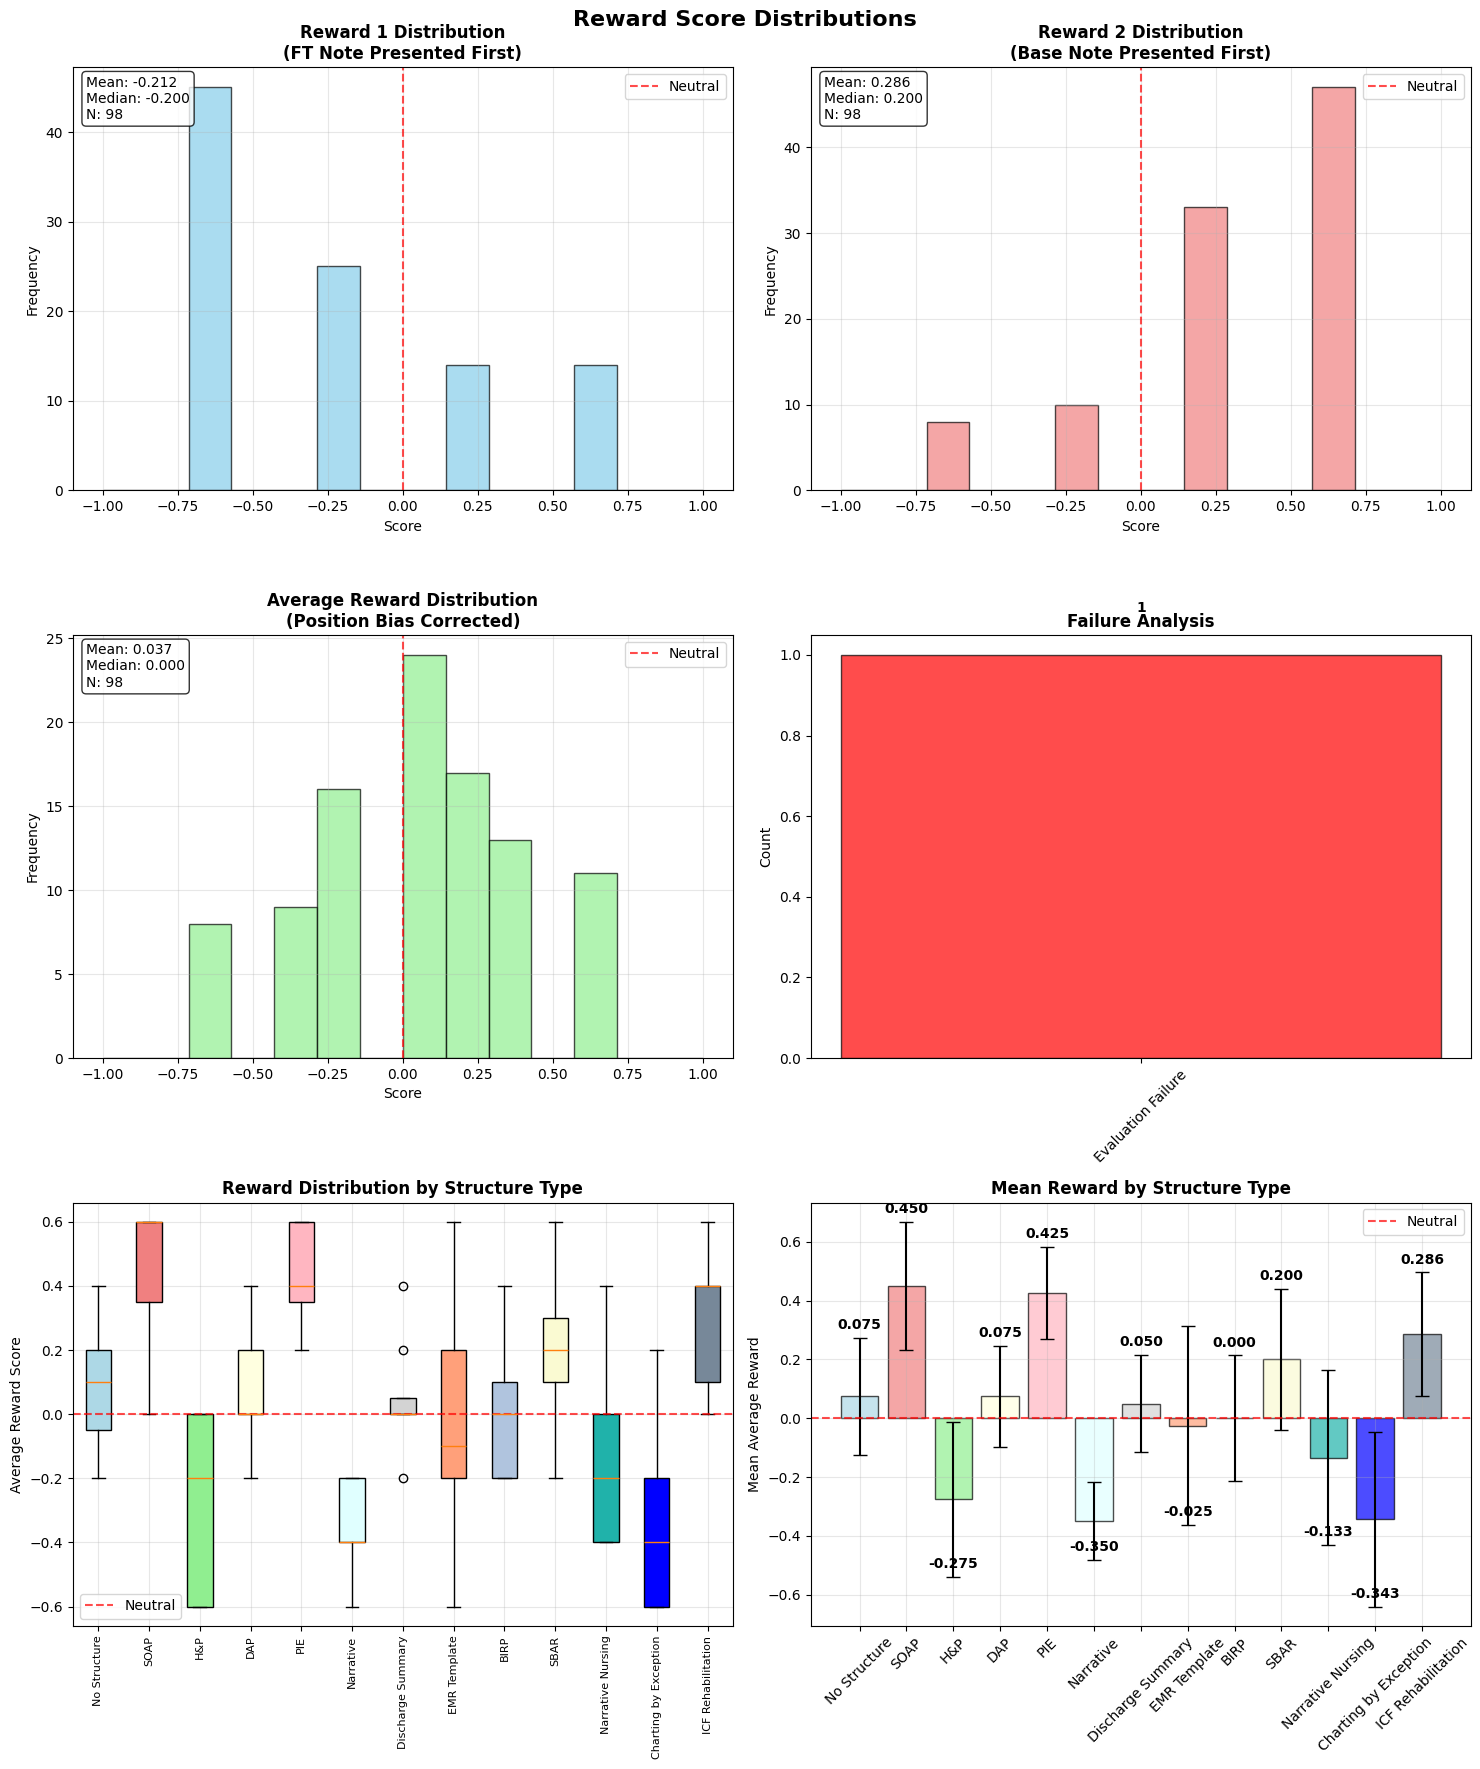

REWARD ANALYSIS SUMMARY
Reward 1 (FT first):     Mean = -0.2122, Std = 0.4331
Reward 2 (Base first):   Mean = 0.2857, Std = 0.3714
Average Reward:          Mean = 0.0367, Std = 0.3433

Position Bias:           -0.4980 (positive = evaluator prefers first option)

Win Rates (based on average reward):
FT Model Wins:           41/98 (41.8%)
Base Model Wins:         33/98 (33.7%)
Ties:                    24/98 (24.5%)

STRUCTURE-SPECIFIC ANALYSIS

No Structure:
  Count:                 8
  Mean Reward:           0.0750 ± 0.1984
  FT Wins:               4/8 (50.0%)
  Base Wins:             2/8 (25.0%)
  Ties:                  2/8 (25.0%)

SOAP:
  Count:                 8
  Mean Reward:           0.4500 ± 0.2179
  FT Wins:               7/8 (87.5%)
  Base Wins:             0/8 (0.0%)
  Ties:                  1/8 (12.5%)

H&P:
  Count:                 8
  Mean Reward:           -0.2750 ± 0.2634
  FT Wins:               0/8 (0.0%)
  Base Wins:             5/8 (62.5%)
  Ties:                  3/

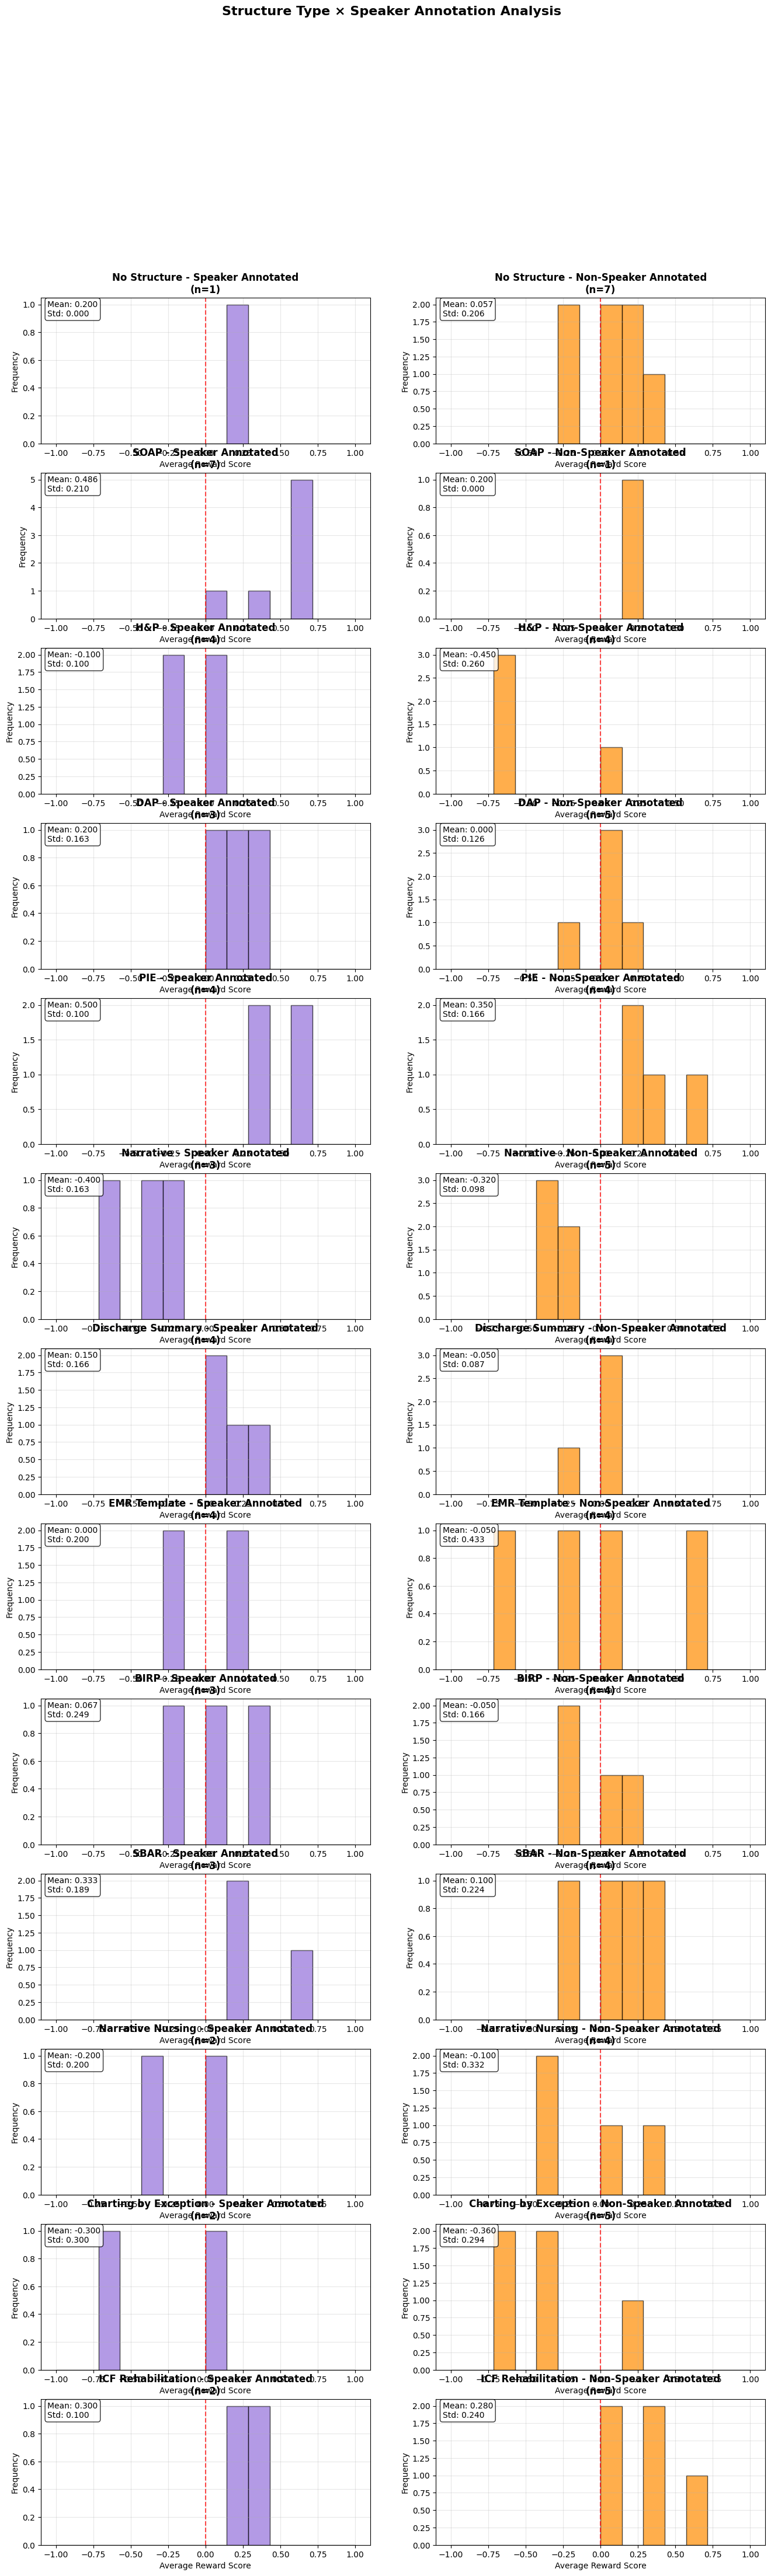

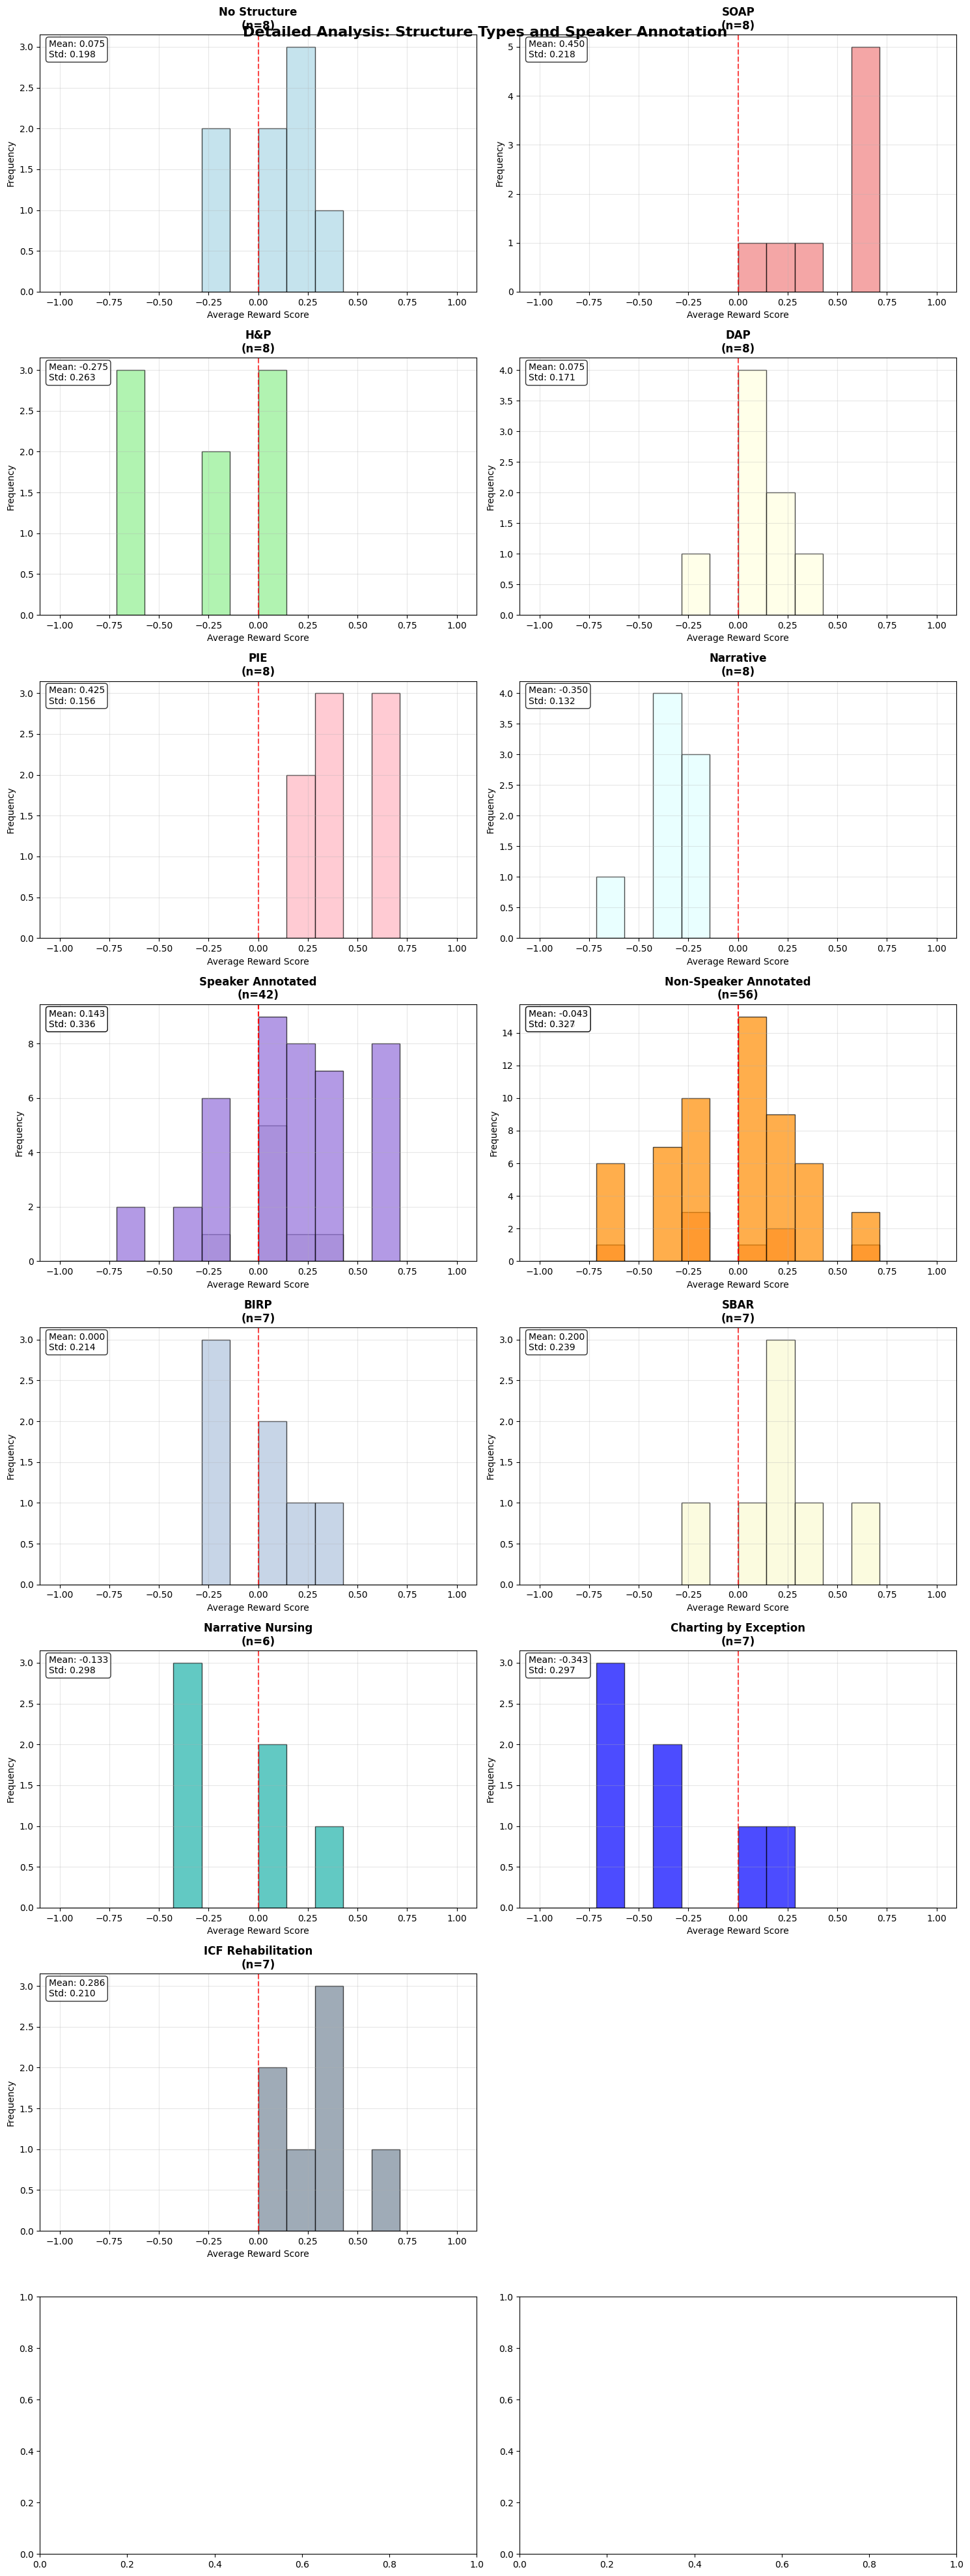

In [ ]:
# %% [code]
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict

# Extract numeric rewards and categorize failures
reward_1_values = []
reward_2_values = []
avg_reward_values = []
failure_counts = Counter()

# Structure-specific analysis
structure_names = [
    "No Structure", "SOAP", "H&P", "DAP", "PIE",
    "Narrative", "Discharge Summary", "EMR Template",
    "BIRP", "SBAR", "Narrative Nursing",
    "Charting by Exception", "ICF Rehabilitation"
]
structure_rewards = defaultdict(list)  # structure_idx -> list of avg rewards
structure_counts = defaultdict(int)    # structure_idx -> count

# Speaker annotation analysis
speaker_annotated_rewards = []  # transcripts starting with "["
non_speaker_annotated_rewards = []  # transcripts not starting with "["

# Combined structure + speaker annotation analysis
combined_rewards = defaultdict(list)  # (structure_idx, is_speaker_annotated) -> list of avg rewards
combined_counts = defaultdict(int)    # (structure_idx, is_speaker_annotated) -> count

# Track failure details for combined analysis
failure_details = []  # List of (failure_type, structure_idx, is_speaker_annotated)

for idx, result in enumerate(rewards):
    r1 = result['reward_1']
    r2 = result['reward_2']
    structure_idx = idx % len(generator_structure_sentences)  # Which structure was used
    transcript = result['transcript']
    is_speaker_annotated = transcript.strip().startswith('[')

    # Handle failures
    if isinstance(r1, str) or isinstance(r2, str):
        failure_type = None
        if r1 == "Dual Failure":
            failure_counts["Dual Failure"] += 1
            failure_type = "Dual Failure"
        elif r1 == "Base Failure" or r2 == "Base Failure":
            failure_counts["Base Failure"] += 1
            failure_type = "Base Failure"
        elif r1 == "FT Failure" or r2 == "FT Failure":
            failure_counts["FT Failure"] += 1
            failure_type = "FT Failure"
        elif r1 == "Evaluation Failure" or r2 == "Evaluation Failure":
            failure_counts["Evaluation Failure"] += 1
            failure_type = "Evaluation Failure"

        # Store failure details
        if failure_type:
            failure_details.append((failure_type, structure_idx, is_speaker_annotated))
        continue

    # Extract numeric rewards
    reward_1_values.append(r1)
    reward_2_values.append(r2)
    avg_reward = (r1 + r2) / 2
    avg_reward_values.append(avg_reward)

    # Store by structure
    structure_rewards[structure_idx].append(avg_reward)
    structure_counts[structure_idx] += 1

    # Store by speaker annotation
    if is_speaker_annotated:
        speaker_annotated_rewards.append(avg_reward)
    else:
        non_speaker_annotated_rewards.append(avg_reward)

    # Store by combined structure + speaker annotation
    combined_rewards[(structure_idx, is_speaker_annotated)].append(avg_reward)
    combined_counts[(structure_idx, is_speaker_annotated)] += 1

# Create figure with subplots - now 3 rows
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
fig.suptitle('Reward Score Distributions', fontsize=16, fontweight='bold')

# Define bins for consistent scaling
bins = np.linspace(-1, 1, 15)
score_labels = {
    -1.0: "Base Substantially Better",
    -2/3: "Base Clearly Better",
    -1/3: "Base Slightly Better",
    0.0: "Neutral",
    1/3: "FT Slightly Better",
    2/3: "FT Clearly Better",
    1.0: "FT Substantially Better"
}

# Histogram 1: Reward 1 (FT first)
axes[0,0].hist(reward_1_values, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Reward 1 Distribution\n(FT Note Presented First)', fontweight='bold')
axes[0,0].set_xlabel('Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# Add score interpretation
if reward_1_values:
    axes[0,0].text(0.02, 0.98, f'Mean: {np.mean(reward_1_values):.3f}\nMedian: {np.median(reward_1_values):.3f}\nN: {len(reward_1_values)}',
                   transform=axes[0,0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Histogram 2: Reward 2 (Base first)
axes[0,1].hist(reward_2_values, bins=bins, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Reward 2 Distribution\n(Base Note Presented First)', fontweight='bold')
axes[0,1].set_xlabel('Score')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

if reward_2_values:
    axes[0,1].text(0.02, 0.98, f'Mean: {np.mean(reward_2_values):.3f}\nMedian: {np.median(reward_2_values):.3f}\nN: {len(reward_2_values)}',
                   transform=axes[0,1].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Histogram 3: Average Rewards
axes[1,0].hist(avg_reward_values, bins=bins, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Average Reward Distribution\n(Position Bias Corrected)', fontweight='bold')
axes[1,0].set_xlabel('Score')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

if avg_reward_values:
    axes[1,0].text(0.02, 0.98, f'Mean: {np.mean(avg_reward_values):.3f}\nMedian: {np.median(avg_reward_values):.3f}\nN: {len(avg_reward_values)}',
                   transform=axes[1,0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Failure Analysis
failure_labels = list(failure_counts.keys())
failure_values = list(failure_counts.values())

if failure_labels:
    colors = ['red', 'orange', 'yellow', 'purple'][:len(failure_labels)]
    axes[1,1].bar(failure_labels, failure_values, color=colors, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Failure Analysis', fontweight='bold')
    axes[1,1].set_ylabel('Count')
    axes[1,1].tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for i, v in enumerate(failure_values):
        axes[1,1].text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
else:
    axes[1,1].text(0.5, 0.5, 'No Failures Detected!', ha='center', va='center',
                   transform=axes[1,1].transAxes, fontsize=14, fontweight='bold', color='green')
    axes[1,1].set_title('Failure Analysis', fontweight='bold')

# Structure-specific analysis (new row)
# Plot 1: Structure comparison box plot
structure_data = []
structure_labels_clean = []
for i in range(len(generator_structure_sentences)):
    if structure_rewards[i]:  # Only include structures with data
        structure_data.append(structure_rewards[i])
        structure_labels_clean.append(structure_names[i])

if structure_data:
    box_plot = axes[2,0].boxplot(structure_data, labels=structure_labels_clean, patch_artist=True)
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink',
          'lightcyan', 'lightgray', 'lightsalmon', 'lightsteelblue', 'lightgoldenrodyellow',
          'lightseagreen', 'blue', 'lightslategray']
    for patch, color in zip(box_plot['boxes'], colors[:len(structure_data)]):
        patch.set_facecolor(color)

    axes[2,0].set_title('Reward Distribution by Structure Type', fontweight='bold')
    axes[2,0].set_ylabel('Average Reward Score')
    axes[2,0].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
    axes[2,0].tick_params(axis='x', rotation=90, labelsize=8)  # Vertical labels, smaller font
    axes[2,0].grid(True, alpha=0.3)
    axes[2,0].legend()
else:
    axes[2,0].text(0.5, 0.5, 'No Structure Data Available', ha='center', va='center',
                   transform=axes[2,0].transAxes, fontsize=14)
    axes[2,0].set_title('Reward Distribution by Structure Type', fontweight='bold')

# Plot 2: Structure mean comparison
if structure_data:
    structure_means = [np.mean(data) for data in structure_data]
    structure_stds = [np.std(data) for data in structure_data]

    bars = axes[2,1].bar(structure_labels_clean, structure_means,
                        yerr=structure_stds, capsize=5, alpha=0.7,
                        color=colors[:len(structure_data)], edgecolor='black')

    axes[2,1].set_title('Mean Reward by Structure Type', fontweight='bold')
    axes[2,1].set_ylabel('Mean Average Reward')
    axes[2,1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
    axes[2,1].tick_params(axis='x', rotation=45)
    axes[2,1].grid(True, alpha=0.3)
    axes[2,1].legend()

    # Add value labels on bars
    for i, (mean, std) in enumerate(zip(structure_means, structure_stds)):
        height = mean + std if mean >= 0 else mean - std
        axes[2,1].text(i, height + 0.02, f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
else:
    axes[2,1].text(0.5, 0.5, 'No Structure Data Available', ha='center', va='center',
                   transform=axes[2,1].transAxes, fontsize=14)
    axes[2,1].set_title('Mean Reward by Structure Type', fontweight='bold')

plt.tight_layout()
plt.show()

# Create a third figure for combined structure + speaker annotation analysis
fig3, axes3 = plt.subplots(13, 2, figsize=(16, 50))
fig3.suptitle('Structure Type × Speaker Annotation Analysis', fontsize=16, fontweight='bold')

for i in range(len(generator_structure_sentences)):
    structure_name = structure_names[i]

    # Speaker Annotated for this structure
    speaker_rewards = combined_rewards[(i, True)]
    non_speaker_rewards = combined_rewards[(i, False)]

    # Left column: Speaker Annotated
    if speaker_rewards:
        axes3[i, 0].hist(speaker_rewards, bins=bins, alpha=0.7,
                        color='mediumpurple', edgecolor='black')
        axes3[i, 0].set_title(f'{structure_name} - Speaker Annotated\n(n={len(speaker_rewards)})', fontweight='bold')
        axes3[i, 0].set_xlabel('Average Reward Score')
        axes3[i, 0].set_ylabel('Frequency')
        axes3[i, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        axes3[i, 0].grid(True, alpha=0.3)

        # Add statistics
        mean_val = np.mean(speaker_rewards)
        std_val = np.std(speaker_rewards)
        axes3[i, 0].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}',
                        transform=axes3[i, 0].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes3[i, 0].text(0.5, 0.5, f'No Speaker Annotated\nData for {structure_name}',
                        ha='center', va='center', transform=axes3[i, 0].transAxes, fontsize=10)
        axes3[i, 0].set_title(f'{structure_name} - Speaker Annotated\n(n=0)', fontweight='bold')

    # Right column: Non-Speaker Annotated
    if non_speaker_rewards:
        axes3[i, 1].hist(non_speaker_rewards, bins=bins, alpha=0.7,
                        color='darkorange', edgecolor='black')
        axes3[i, 1].set_title(f'{structure_name} - Non-Speaker Annotated\n(n={len(non_speaker_rewards)})', fontweight='bold')
        axes3[i, 1].set_xlabel('Average Reward Score')
        axes3[i, 1].set_ylabel('Frequency')
        axes3[i, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
        axes3[i, 1].grid(True, alpha=0.3)

        # Add statistics
        mean_val = np.mean(non_speaker_rewards)
        std_val = np.std(non_speaker_rewards)
        axes3[i, 1].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}',
                        transform=axes3[i, 1].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes3[i, 1].text(0.5, 0.5, f'No Non-Speaker Annotated\nData for {structure_name}',
                        ha='center', va='center', transform=axes3[i, 1].transAxes, fontsize=10)
        axes3[i, 1].set_title(f'{structure_name} - Non-Speaker Annotated\n(n=0)', fontweight='bold')

# Print summary statistics
print("="*60)
print("REWARD ANALYSIS SUMMARY")
print("="*60)

if reward_1_values:
    print(f"Reward 1 (FT first):     Mean = {np.mean(reward_1_values):.4f}, Std = {np.std(reward_1_values):.4f}")
    print(f"Reward 2 (Base first):   Mean = {np.mean(reward_2_values):.4f}, Std = {np.std(reward_2_values):.4f}")
    print(f"Average Reward:          Mean = {np.mean(avg_reward_values):.4f}, Std = {np.std(avg_reward_values):.4f}")

    # Position bias analysis
    position_bias = np.mean(reward_1_values) - np.mean(reward_2_values)
    print(f"\nPosition Bias:           {position_bias:.4f} (positive = evaluator prefers first option)")

    # Win rate analysis
    ft_wins = sum(1 for avg in avg_reward_values if avg > 0)
    base_wins = sum(1 for avg in avg_reward_values if avg < 0)
    ties = sum(1 for avg in avg_reward_values if avg == 0)
    total_valid = len(avg_reward_values)

    print(f"\nWin Rates (based on average reward):")
    print(f"FT Model Wins:           {ft_wins}/{total_valid} ({ft_wins/total_valid*100:.1f}%)")
    print(f"Base Model Wins:         {base_wins}/{total_valid} ({base_wins/total_valid*100:.1f}%)")
    print(f"Ties:                    {ties}/{total_valid} ({ties/total_valid*100:.1f}%)")

else:
    print("No valid numeric rewards found!")

# Structure-specific analysis
print(f"\n" + "="*60)
print("STRUCTURE-SPECIFIC ANALYSIS")
print("="*60)

for i in range(len(generator_structure_sentences)):
    structure_name = structure_names[i]
    rewards_for_structure = structure_rewards[i]
    count = structure_counts[i]

    if rewards_for_structure:
        mean_reward = np.mean(rewards_for_structure)
        std_reward = np.std(rewards_for_structure)
        ft_wins_struct = sum(1 for r in rewards_for_structure if r > 0)
        base_wins_struct = sum(1 for r in rewards_for_structure if r < 0)
        ties_struct = sum(1 for r in rewards_for_structure if r == 0)

        print(f"\n{structure_name}:")
        print(f"  Count:                 {count}")
        print(f"  Mean Reward:           {mean_reward:.4f} ± {std_reward:.4f}")
        print(f"  FT Wins:               {ft_wins_struct}/{count} ({ft_wins_struct/count*100:.1f}%)")
        print(f"  Base Wins:             {base_wins_struct}/{count} ({base_wins_struct/count*100:.1f}%)")
        print(f"  Ties:                  {ties_struct}/{count} ({ties_struct/count*100:.1f}%)")
    else:
        print(f"\n{structure_name}:")
        print(f"  No valid data available")

# Speaker annotation analysis
print(f"\n" + "="*60)
print("SPEAKER ANNOTATION ANALYSIS")
print("="*60)

if speaker_annotated_rewards:
    mean_speaker = np.mean(speaker_annotated_rewards)
    std_speaker = np.std(speaker_annotated_rewards)
    ft_wins_speaker = sum(1 for r in speaker_annotated_rewards if r > 0)
    base_wins_speaker = sum(1 for r in speaker_annotated_rewards if r < 0)
    ties_speaker = sum(1 for r in speaker_annotated_rewards if r == 0)
    count_speaker = len(speaker_annotated_rewards)

    print(f"\nSpeaker Annotated (starts with '['):")
    print(f"  Count:                 {count_speaker}")
    print(f"  Mean Reward:           {mean_speaker:.4f} ± {std_speaker:.4f}")
    print(f"  FT Wins:               {ft_wins_speaker}/{count_speaker} ({ft_wins_speaker/count_speaker*100:.1f}%)")
    print(f"  Base Wins:             {base_wins_speaker}/{count_speaker} ({base_wins_speaker/count_speaker*100:.1f}%)")
    print(f"  Ties:                  {ties_speaker}/{count_speaker} ({ties_speaker/count_speaker*100:.1f}%)")
else:
    print(f"\nSpeaker Annotated (starts with '['):")
    print(f"  No valid data available")

if non_speaker_annotated_rewards:
    mean_non_speaker = np.mean(non_speaker_annotated_rewards)
    std_non_speaker = np.std(non_speaker_annotated_rewards)
    ft_wins_non_speaker = sum(1 for r in non_speaker_annotated_rewards if r > 0)
    base_wins_non_speaker = sum(1 for r in non_speaker_annotated_rewards if r < 0)
    ties_non_speaker = sum(1 for r in non_speaker_annotated_rewards if r == 0)
    count_non_speaker = len(non_speaker_annotated_rewards)

    print(f"\nNon-Speaker Annotated (does not start with '['):")
    print(f"  Count:                 {count_non_speaker}")
    print(f"  Mean Reward:           {mean_non_speaker:.4f} ± {std_non_speaker:.4f}")
    print(f"  FT Wins:               {ft_wins_non_speaker}/{count_non_speaker} ({ft_wins_non_speaker/count_non_speaker*100:.1f}%)")
    print(f"  Base Wins:             {base_wins_non_speaker}/{count_non_speaker} ({base_wins_non_speaker/count_non_speaker*100:.1f}%)")
    print(f"  Ties:                  {ties_non_speaker}/{count_non_speaker} ({ties_non_speaker/count_non_speaker*100:.1f}%)")
else:
    print(f"\nNon-Speaker Annotated (does not start with '['):")
    print(f"  No valid data available")

# Compare speaker vs non-speaker if both have data
if speaker_annotated_rewards and non_speaker_annotated_rewards:
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(speaker_annotated_rewards, non_speaker_annotated_rewards)
    print(f"\nStatistical Comparison (t-test):")
    print(f"  Difference in means:   {mean_speaker - mean_non_speaker:.4f}")
    print(f"  T-statistic:           {t_stat:.4f}")
    print(f"  P-value:               {p_value:.4f}")
    if p_value < 0.05:
        print(f"  Result:                Statistically significant difference (p < 0.05)")
    else:
        print(f"  Result:                No significant difference (p >= 0.05)")

# Combined structure + speaker annotation analysis
print(f"\n" + "="*80)
print("COMBINED STRUCTURE × SPEAKER ANNOTATION ANALYSIS")
print("="*80)

for i in range(len(generator_structure_sentences)):
    structure_name = structure_names[i]
    print(f"\n{structure_name.upper()}:")
    print("-" * (len(structure_name) + 1))

    # Speaker Annotated
    speaker_rewards = combined_rewards[(i, True)]
    if speaker_rewards:
        mean_speaker = np.mean(speaker_rewards)
        std_speaker = np.std(speaker_rewards)
        ft_wins_speaker = sum(1 for r in speaker_rewards if r > 0)
        base_wins_speaker = sum(1 for r in speaker_rewards if r < 0)
        ties_speaker = sum(1 for r in speaker_rewards if r == 0)
        count_speaker = len(speaker_rewards)

        print(f"  Speaker Annotated:")
        print(f"    Count:               {count_speaker}")
        print(f"    Mean Reward:         {mean_speaker:.4f} ± {std_speaker:.4f}")
        print(f"    FT Wins:             {ft_wins_speaker}/{count_speaker} ({ft_wins_speaker/count_speaker*100:.1f}%)")
        print(f"    Base Wins:           {base_wins_speaker}/{count_speaker} ({base_wins_speaker/count_speaker*100:.1f}%)")
        print(f"    Ties:                {ties_speaker}/{count_speaker} ({ties_speaker/count_speaker*100:.1f}%)")
    else:
        print(f"  Speaker Annotated:     No data available")

    # Non-Speaker Annotated
    non_speaker_rewards = combined_rewards[(i, False)]
    if non_speaker_rewards:
        mean_non_speaker = np.mean(non_speaker_rewards)
        std_non_speaker = np.std(non_speaker_rewards)
        ft_wins_non_speaker = sum(1 for r in non_speaker_rewards if r > 0)
        base_wins_non_speaker = sum(1 for r in non_speaker_rewards if r < 0)
        ties_non_speaker = sum(1 for r in non_speaker_rewards if r == 0)
        count_non_speaker = len(non_speaker_rewards)

        print(f"  Non-Speaker Annotated:")
        print(f"    Count:               {count_non_speaker}")
        print(f"    Mean Reward:         {mean_non_speaker:.4f} ± {std_non_speaker:.4f}")
        print(f"    FT Wins:             {ft_wins_non_speaker}/{count_non_speaker} ({ft_wins_non_speaker/count_non_speaker*100:.1f}%)")
        print(f"    Base Wins:           {base_wins_non_speaker}/{count_non_speaker} ({base_wins_non_speaker/count_non_speaker*100:.1f}%)")
        print(f"    Ties:                {ties_non_speaker}/{count_non_speaker} ({ties_non_speaker/count_non_speaker*100:.1f}%)")
    else:
        print(f"  Non-Speaker Annotated: No data available")

    # Statistical comparison within this structure type
    if speaker_rewards and non_speaker_rewards and len(speaker_rewards) > 1 and len(non_speaker_rewards) > 1:
        try:
            from scipy import stats
            t_stat, p_value = stats.ttest_ind(speaker_rewards, non_speaker_rewards)
            print(f"  Statistical Comparison (Speaker vs Non-Speaker):")
            print(f"    Difference in means: {mean_speaker - mean_non_speaker:.4f}")
            print(f"    T-statistic:         {t_stat:.4f}")
            print(f"    P-value:             {p_value:.4f}")
            if p_value < 0.05:
                print(f"    Result:              Significant difference (p < 0.05)")
            else:
                print(f"    Result:              No significant difference (p >= 0.05)")
        except:
            print(f"  Statistical Comparison: Could not perform t-test")
    elif speaker_rewards and non_speaker_rewards:
        print(f"  Statistical Comparison: Insufficient data for t-test")

# Failure breakdown by structure × speaker annotation combinations
print(f"\n" + "="*80)
print("FAILURE BREAKDOWN BY STRUCTURE × SPEAKER ANNOTATION")
print("="*80)

if failure_details:
    # Count failures by combination
    failure_combination_counts = defaultdict(lambda: defaultdict(int))

    for failure_type, structure_idx, is_speaker_annotated in failure_details:
        structure_name = structure_names[structure_idx]
        annotation_type = "Speaker Annotated" if is_speaker_annotated else "Non-Speaker Annotated"
        failure_combination_counts[failure_type][(structure_name, annotation_type)] += 1

    # Print detailed breakdown
    for failure_type in ["FT Failure", "Base Failure", "Dual Failure", "Evaluation Failure"]:
        if failure_type in failure_combination_counts:
            print(f"\n{failure_type.upper()}:")
            print("-" * (len(failure_type) + 1))

            combinations = failure_combination_counts[failure_type]
            if combinations:
                for (structure_name, annotation_type), count in sorted(combinations.items()):
                    print(f"  {structure_name} + {annotation_type}: {count}")
            else:
                print(f"  No failures of this type")

    # Summary table format
    print(f"\n" + "="*80)
    print("FAILURE SUMMARY TABLE")
    print("="*80)
    print(f"{'Structure':<20} {'Annotation':<20} {'FT':<4} {'Base':<4} {'Dual':<4} {'Eval':<4} {'Total':<5}")
    print("-" * 80)

    # Initialize summary
    summary_data = {}
    for i, structure_name in enumerate(structure_names):
        for annotation_type in ["Speaker Annotated", "Non-Speaker Annotated"]:
            key = (structure_name, annotation_type)
            summary_data[key] = {"FT Failure": 0, "Base Failure": 0, "Dual Failure": 0, "Evaluation Failure": 0}

    # Fill in actual counts
    for failure_type, structure_idx, is_speaker_annotated in failure_details:
        structure_name = structure_names[structure_idx]
        annotation_type = "Speaker Annotated" if is_speaker_annotated else "Non-Speaker Annotated"
        summary_data[(structure_name, annotation_type)][failure_type] += 1

    # Print table
    for structure_name in structure_names:
        for annotation_type in ["Speaker Annotated", "Non-Speaker Annotated"]:
            key = (structure_name, annotation_type)
            counts = summary_data[key]
            ft_count = counts["FT Failure"]
            base_count = counts["Base Failure"]
            dual_count = counts["Dual Failure"]
            eval_count = counts["Evaluation Failure"]
            total_count = ft_count + base_count + dual_count + eval_count

            if total_count > 0:  # Only print rows with failures
                print(f"{structure_name:<20} {annotation_type:<20} {ft_count:<4} {base_count:<4} {dual_count:<4} {eval_count:<4} {total_count:<5}")
else:
    print("No failures detected in the dataset!")

if failure_counts:
    print(f"\n" + "="*60)
    print("FAILURE ANALYSIS")
    print("="*60)
    for failure_type, count in failure_counts.items():
        print(f"{failure_type}:".ljust(25) + f"{count}")

print(f"\n" + "="*60)
print("OVERALL SUMMARY")
print("="*60)
print(f"Total Processed:         {len(rewards)}")
print(f"Valid Evaluations:       {len(avg_reward_values)}")
print(f"Failed Evaluations:      {sum(failure_counts.values())}")
print("="*60)

# Create a separate figure for individual structure histograms + speaker annotation
fig2, axes2 = plt.subplots(8, 2, figsize=(15, 40))  # 8 rows: 7 for structures + 1 for speaker analysis
fig2.suptitle('Detailed Analysis: Structure Types and Speaker Annotation', fontsize=16, fontweight='bold')

# Plot histogram for each structure type (first 5 subplots)
for i in range(len(generator_structure_sentences)):
    row = i // 2
    col = i % 2

    if row < 7:  # Only plot if we have room (7 rows available for structures)

        rewards_for_structure = structure_rewards[i]
        structure_name = structure_names[i]

        if rewards_for_structure:
            axes2[row, col].hist(rewards_for_structure, bins=bins, alpha=0.7,
                                color=colors[i], edgecolor='black')
            axes2[row, col].set_title(f'{structure_name}\n(n={len(rewards_for_structure)})', fontweight='bold')
            axes2[row, col].set_xlabel('Average Reward Score')
            axes2[row, col].set_ylabel('Frequency')
            axes2[row, col].axvline(x=0, color='red', linestyle='--', alpha=0.7)
            axes2[row, col].grid(True, alpha=0.3)

            # Add statistics
            mean_val = np.mean(rewards_for_structure)
            std_val = np.std(rewards_for_structure)
            axes2[row, col].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}',
                                transform=axes2[row, col].transAxes, verticalalignment='top',
                                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            axes2[row, col].text(0.5, 0.5, f'No Data\nfor {structure_name}', ha='center', va='center',
                                transform=axes2[row, col].transAxes, fontsize=12)
            axes2[row, col].set_title(f'{structure_name}\n(n=0)', fontweight='bold')

if len(generator_structure_sentences) % 2 == 1:
    axes2[6, 1].axis('off')

# Speaker Annotation Analysis (row 3)
# Speaker Annotated transcripts
if speaker_annotated_rewards:
    axes2[3, 0].hist(speaker_annotated_rewards, bins=bins, alpha=0.7,
                    color='mediumpurple', edgecolor='black')
    axes2[3, 0].set_title(f'Speaker Annotated\n(n={len(speaker_annotated_rewards)})', fontweight='bold')
    axes2[3, 0].set_xlabel('Average Reward Score')
    axes2[3, 0].set_ylabel('Frequency')
    axes2[3, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes2[3, 0].grid(True, alpha=0.3)

    # Add statistics
    mean_speaker = np.mean(speaker_annotated_rewards)
    std_speaker = np.std(speaker_annotated_rewards)
    axes2[3, 0].text(0.02, 0.98, f'Mean: {mean_speaker:.3f}\nStd: {std_speaker:.3f}',
                    transform=axes2[3, 0].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    axes2[3, 0].text(0.5, 0.5, 'No Speaker\nAnnotated Data', ha='center', va='center',
                    transform=axes2[3, 0].transAxes, fontsize=12)
    axes2[3, 0].set_title('Speaker Annotated\n(n=0)', fontweight='bold')

# Non-Speaker Annotated transcripts
if non_speaker_annotated_rewards:
    axes2[3, 1].hist(non_speaker_annotated_rewards, bins=bins, alpha=0.7,
                    color='darkorange', edgecolor='black')
    axes2[3, 1].set_title(f'Non-Speaker Annotated\n(n={len(non_speaker_annotated_rewards)})', fontweight='bold')
    axes2[3, 1].set_xlabel('Average Reward Score')
    axes2[3, 1].set_ylabel('Frequency')
    axes2[3, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes2[3, 1].grid(True, alpha=0.3)

    # Add statistics
    mean_non_speaker = np.mean(non_speaker_annotated_rewards)
    std_non_speaker = np.std(non_speaker_annotated_rewards)
    axes2[3, 1].text(0.02, 0.98, f'Mean: {mean_non_speaker:.3f}\nStd: {std_non_speaker:.3f}',
                    transform=axes2[3, 1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    axes2[3, 1].text(0.5, 0.5, 'No Non-Speaker\nAnnotated Data', ha='center', va='center',
                    transform=axes2[3, 1].transAxes, fontsize=12)
    axes2[3, 1].set_title('Non-Speaker Annotated\n(n=0)', fontweight='bold')

plt.tight_layout()
plt.show()


